In [57]:
import json
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


with open('backtest_result.json') as f:
    data = json.load(f)

daily_return = {}

start_date = '2023-01-01 00:00:00'
end_date = '2024-06-05 00:00:00'

date_range = pd.date_range(start=start_date, end=end_date, freq='H')

date_list = date_range.to_list()

for date in date_range:
    daily_return[date] = 0
    
for symbol in data.keys():    
    df = pd.read_json(data[symbol])
    try:
        target = df[df['signal'] == -1]
    except:
        pass
    if len(target) >= 1:
        for i in range(len(target)):
            try:
                daily_return[target.iloc[i]['datetime']] += target.iloc[i]['strategy_return']
            except:
                print(symbol)
    
print(daily_return)

SPELLUSDT
SPELLUSDT
SPELLUSDT
SPELLUSDT
SPELLUSDT
PEOPLEUSDT
ENSUSDT
ONDOUSDT
JASMYUSDT
ALICEUSDT
NOTUSDT
TNSRUSDT
{Timestamp('2023-01-01 00:00:00'): 0, Timestamp('2023-01-01 01:00:00'): 0, Timestamp('2023-01-01 02:00:00'): 0.0091264668, Timestamp('2023-01-01 03:00:00'): 0, Timestamp('2023-01-01 04:00:00'): 0.0203810011, Timestamp('2023-01-01 05:00:00'): 0, Timestamp('2023-01-01 06:00:00'): 0.0051813472, Timestamp('2023-01-01 07:00:00'): 0, Timestamp('2023-01-01 08:00:00'): 0, Timestamp('2023-01-01 09:00:00'): 0, Timestamp('2023-01-01 10:00:00'): 0.0188355896, Timestamp('2023-01-01 11:00:00'): 0, Timestamp('2023-01-01 12:00:00'): 0, Timestamp('2023-01-01 13:00:00'): 0, Timestamp('2023-01-01 14:00:00'): 0, Timestamp('2023-01-01 15:00:00'): 0, Timestamp('2023-01-01 16:00:00'): 0, Timestamp('2023-01-01 17:00:00'): 0, Timestamp('2023-01-01 18:00:00'): 0.0200298879, Timestamp('2023-01-01 19:00:00'): 0.0312423312, Timestamp('2023-01-01 20:00:00'): 0, Timestamp('2023-01-01 21:00:00'): 0, Time

In [61]:
# draw analysis plot of daily_return
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

accumulated_return = {}
for key in daily_return.keys():
    if key == list(daily_return.keys())[0]:
        accumulated_return[key] = daily_return[key]
    else:
        accumulated_return[key] = accumulated_return[list(accumulated_return.keys())[-1]] + daily_return[key]


{Timestamp('2023-01-01 00:00:00'): 0,
 Timestamp('2023-01-01 01:00:00'): 0,
 Timestamp('2023-01-01 02:00:00'): 0.0091264668,
 Timestamp('2023-01-01 03:00:00'): 0.0091264668,
 Timestamp('2023-01-01 04:00:00'): 0.0295074679,
 Timestamp('2023-01-01 05:00:00'): 0.0295074679,
 Timestamp('2023-01-01 06:00:00'): 0.0346888151,
 Timestamp('2023-01-01 07:00:00'): 0.0346888151,
 Timestamp('2023-01-01 08:00:00'): 0.0346888151,
 Timestamp('2023-01-01 09:00:00'): 0.0346888151,
 Timestamp('2023-01-01 10:00:00'): 0.0535244047,
 Timestamp('2023-01-01 11:00:00'): 0.0535244047,
 Timestamp('2023-01-01 12:00:00'): 0.0535244047,
 Timestamp('2023-01-01 13:00:00'): 0.0535244047,
 Timestamp('2023-01-01 14:00:00'): 0.0535244047,
 Timestamp('2023-01-01 15:00:00'): 0.0535244047,
 Timestamp('2023-01-01 16:00:00'): 0.0535244047,
 Timestamp('2023-01-01 17:00:00'): 0.0535244047,
 Timestamp('2023-01-01 18:00:00'): 0.0735542926,
 Timestamp('2023-01-01 19:00:00'): 0.1047966238,
 Timestamp('2023-01-01 20:00:00'): 0.10479

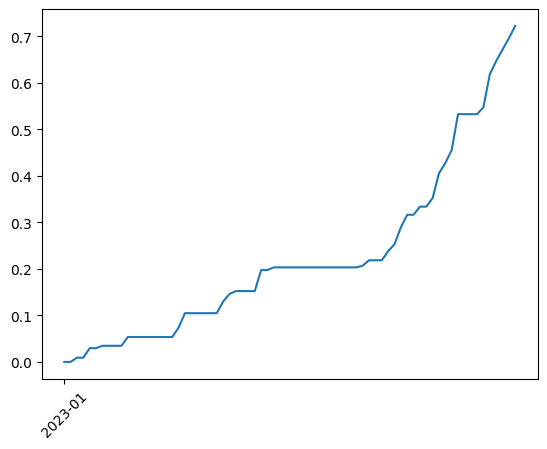

Total return:  nan
Total return rate:  nan
Max drawdown:  0
Max drawdown start:  None
Max drawdown end:  None


TypeError: '>' not supported between instances of 'float' and 'NoneType'

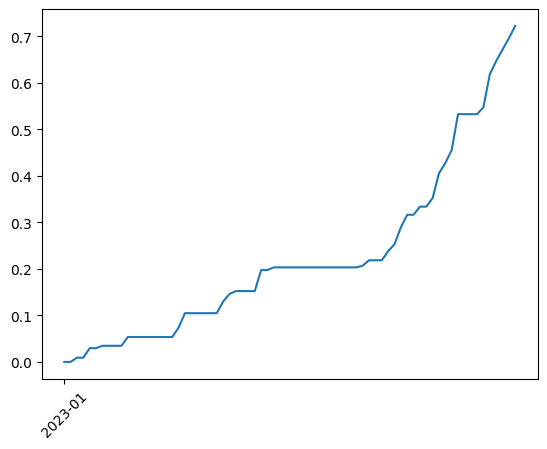

In [60]:
# from 2022-01-01
start = datetime.datetime(2022, 9, 1)
accumulated_return = {k: v for k, v in accumulated_return.items() if k >= start}

fig, ax = plt.subplots()
ax.plot(accumulated_return.keys(), accumulated_return.values())
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()


# calculate the total return
total_return = 0
for key in daily_return.keys():
    total_return += daily_return[key]
print('Total return: ', total_return)
print('Total return rate: ', total_return/10000)

# calculate the max drawdown
# max_drawdown = 0
# max_drawdown_start = None
# max_drawdown_end = None
# current_max = 0
# current_max_date = None
# for key in accumulated_return.keys():
#     if accumulated_return[key] > current_max:
#         current_max = accumulated_return[key]
#         current_max_date = key
#     if current_max - accumulated_return[key] > max_drawdown:
#         max_drawdown = current_max - accumulated_return[key]
#         max_drawdown_start = current_max_date
#         max_drawdown_end = key
# print('Max drawdown: ', max_drawdown)
# print('Max drawdown start: ', max_drawdown_start)
# print('Max drawdown end: ', max_drawdown_end)

# # draw the max drawdown plot
# fig, ax = plt.subplots()
# ax.plot(accumulated_return.keys(), accumulated_return.values())
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.xticks(rotation=45)
# plt.axvline(x=max_drawdown_start, color='r', linestyle='--')
# plt.axvline(x=max_drawdown_end, color='r', linestyle='--')
# plt.show()

